In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv("Electrical Grid.csv")
data_x = data.drop(['stab','stabf'],axis=1)
data_y = data['stab']

scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(data_x)
scaled_x = pd.DataFrame(scaled_x, columns=data_x.columns)

def get_random_subset(iterable,k):
    subsets = []
    iteration = 0
    np.random.shuffle(iterable)
    subset = 0
    limit = len(iterable)/k
    while iteration < limit:
        if k <= len(iterable):
            subset = k
        else:
            subset = len(iterable)
        subsets.append(iterable[-subset:])
        del iterable[-subset:]
        iteration+=1
    return subsets

def Rotation_Forest(X , Y, test_x, max_depth, size, n_trees, k):
  r_matrices , models = [],[]

  for tree in range(n_trees):
    feature_index = list(range(X.shape[1]))
    k_subset = get_random_subset(feature_index,k) #每個子集有k個特徵，每個子集特徵不重複 #將訓練集中的屬性拆分為大小相等的 K 個非重疊子集。
    rotation_matrix = np.zeros((X.shape[1],X.shape[1]),dtype=float) #591*591大小的矩陣

    for each_subset in k_subset:
      pca = PCA()
      X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=size)
      X_subset = X_train.iloc[:,each_subset]
      pca.fit(X_subset)
      for i in range(0,len(pca.components_)):
        for j in range(0,len(pca.components_)):
          rotation_matrix[each_subset[i],each_subset[j]] = pca.components_[i,j]

    x_transformed = X.dot(rotation_matrix)
    model = DecisionTreeRegressor(max_depth = max_depth)
    model.fit(x_transformed,Y)
    models.append(model) #存放每個樹的模型
    r_matrices.append(rotation_matrix) #存放每個樹的旋轉矩陣

  return models,r_matrices

def model_predict(models,r_matrices,x):
    predicted_ys = []
    for i,model in enumerate(models):
        x_mod =  x.dot(r_matrices[i])
        predicted_y = model.predict(x_mod)
        predicted_ys.append(predicted_y)

    final_results = []
    for i in range(len(predicted_ys[0])): #總共要預測的Y有幾個 #2000個預測值
        predict_result = [] #存放每棵樹的預測值 #100棵樹有100個預測值
        for j in range(len(predicted_ys)): #每棵樹的預測值 #100棵樹
            predict_result.append( (predicted_ys[j][i]) )
        final_results.append(np.mean(predict_result))

    return final_results

kf = KFold(n_splits=5, shuffle=True, random_state=42)

Mounted at /content/drive


300
500
700
900
[0.011935194819352343, 0.011903701684434395, 0.011841402667654518, 0.011860734481628712]


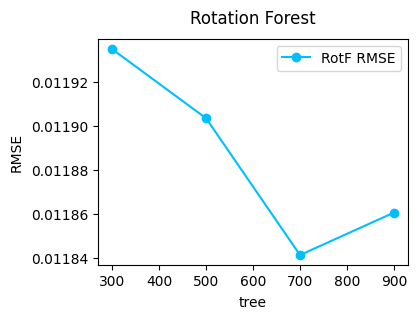

In [ ]:
RMSE_set_rf_depth = []
import matplotlib.pyplot as plt

trees = [300,500,700,900]

for tree in trees:
    print(tree)
    RMSE_set_rf ,mape_set_rf= [],[]
    for train_index, valid_index in kf.split(scaled_x, data_y): # split()  method generate indices to split data intSo training and test set.
        #print('fold',cnt)
        train_x = scaled_x.iloc[train_index,:]
        train_y = data.iloc[train_index,:]['stab']
        valid_x = scaled_x.iloc[valid_index,:]
        valid_y = data.iloc[valid_index,:]['stab']

        models,r_matrices = Rotation_Forest( X = train_x , Y = train_y ,test_x = valid_x, max_depth=20, size=0.7, n_trees=tree, k =3 )
        rot_pred = model_predict(models,r_matrices,valid_x)
        RMSE_set_rf.append( np.sqrt( mean_squared_error(valid_y,rot_pred)))

    RMSE_set_rf_depth.append( np.mean(RMSE_set_rf) )

print(RMSE_set_rf_depth)
plt.figure(figsize=(4,3),dpi=100,linewidth = 2)
plt.plot(trees,RMSE_set_rf_depth,'o-',color = 'deepskyblue', label="RotF RMSE")
plt.title("Rotation Forest", x=0.5, y=1.03)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("tree", fontsize=10, labelpad = 5)
plt.ylabel("RMSE", fontsize=10, labelpad = 5)
plt.legend(loc = "best", fontsize=10)
plt.show()

10
20
30
40
50
[0.01318715683835663, 0.01195255264059479, 0.011940873635565692, 0.011861025031839308, 0.011974369919367085]


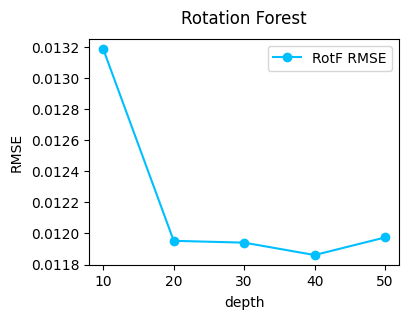

In [ ]:
RMSE_set_rf_depth = []
import matplotlib.pyplot as plt

depths = [10,20,30,40,50]

for depth in depths:
    print(depth)
    RMSE_set_rf ,mape_set_rf= [],[]
    for train_index, valid_index in kf.split(scaled_x, data_y): # split()  method generate indices to split data intSo training and test set.
        #print('fold',cnt)
        train_x = scaled_x.iloc[train_index,:]
        train_y = data.iloc[train_index,:]['stab']
        valid_x = scaled_x.iloc[valid_index,:]
        valid_y = data.iloc[valid_index,:]['stab']

        models,r_matrices = Rotation_Forest(X=train_x,Y=train_y,test_x=valid_x, max_depth=depth, size=0.7, n_trees=300, k =3 )
        rot_pred = model_predict(models,r_matrices,valid_x)
        RMSE_set_rf.append( np.sqrt( mean_squared_error(valid_y,rot_pred)))

    RMSE_set_rf_depth.append( np.mean(RMSE_set_rf) )

print(RMSE_set_rf_depth)
plt.figure(figsize=(4,3),dpi=100,linewidth = 2)
plt.plot(depths,RMSE_set_rf_depth,'o-',color = 'deepskyblue', label="RotF RMSE")
plt.title("Rotation Forest", x=0.5, y=1.03)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("depth", fontsize=10, labelpad = 5)
plt.ylabel("RMSE", fontsize=10, labelpad = 5)
plt.legend(loc = "best", fontsize=10)
plt.show()

0.5
0.7
0.9
[0.011881419063251391, 0.011926645766112803, 0.011899747506331557]


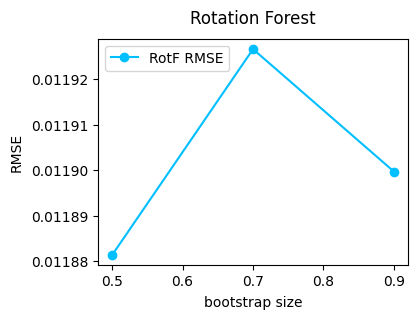

In [ ]:
RMSE_set_rf_depth = []
import matplotlib.pyplot as plt

bootstrap_sizes = [0.5,0.7,0.9]

for bootstrap_size in bootstrap_sizes:
    print(bootstrap_size)
    RMSE_set_rf ,mape_set_rf= [],[]
    for train_index, valid_index in kf.split(scaled_x, data_y): # split()  method generate indices to split data intSo training and test set.
        #print('fold',cnt)
        train_x = scaled_x.iloc[train_index,:]
        train_y = data.iloc[train_index,:]['stab']
        valid_x = scaled_x.iloc[valid_index,:]
        valid_y = data.iloc[valid_index,:]['stab']

        models,r_matrices = Rotation_Forest(X=train_x,Y=train_y,test_x=valid_x,max_depth=30,size=bootstrap_size,n_trees=300,k=3)
        rot_pred = model_predict(models,r_matrices,valid_x)
        RMSE_set_rf.append( np.sqrt( mean_squared_error(valid_y,rot_pred)))

    RMSE_set_rf_depth.append( np.mean(RMSE_set_rf) )

print(RMSE_set_rf_depth)
plt.figure(figsize=(4,3),dpi=100,linewidth = 2)
plt.plot(bootstrap_sizes,RMSE_set_rf_depth,'o-',color = 'deepskyblue', label="RotF RMSE")
plt.title("Rotation Forest", x=0.5, y=1.03)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("bootstrap size", fontsize=10, labelpad = 5)
plt.ylabel("RMSE", fontsize=10, labelpad = 5)
plt.legend(loc = "best", fontsize=10)
plt.show()

In [ ]:
bootstrap_sizes = [0.5,0.7,0.9]
RMSE_set_rf_depth = [0.011881419063251391, 0.011926645766112803, 0.011899747506331557]

plt.figure(figsize=(4,3),dpi=100,linewidth = 2)
plt.plot(bootstrap_sizes,RMSE_set_rf_depth,'o-',color = 'tab:orange', label="RotF RMSE")
plt.title("RotF", x=0.5, y=1.03)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("bootstrap size", fontsize=10, labelpad = 5)
plt.ylabel("RMSE", fontsize=10, labelpad = 5)
plt.legend(loc = "best", fontsize=10)
plt.show()

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cnt = 1
RMSE_set_rotf = []
for train_index, valid_index in kf.split(scaled_x, data_y): # split()  method generate indices to split data intSo training and test set.
    print('fold',cnt)
    train_x = scaled_x.iloc[train_index,:]
    train_y = data.iloc[train_index,:]['stab']
    valid_x = scaled_x.iloc[valid_index,:]
    valid_y = data.iloc[valid_index,:]['stab']
    models,r_matrices = Rotation_Forest(X=train_x,Y=train_y,test_x=valid_x, max_depth= 40, size=0.5, n_trees=700, k =3 )
    rot_pred = model_predict(models,r_matrices,valid_x)
    RMSE_set_rotf.append( np.sqrt( mean_squared_error(valid_y,rot_pred)))
    cnt+=1

print("rof",RMSE_set_rotf)
print("mean",np.mean(RMSE_set_rotf) )

fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
rof [0.0119967104100166, 0.011837401020090649, 0.011881652323350454, 0.011519475601084538, 0.011522526722381087, 0.011289227860356856, 0.011101216729294957, 0.011749969714693519, 0.01164152945500119, 0.012547376900432661]
mean 0.01170870867367025
